In [1]:
# Cell 1: Install Libraries & Check Transformers Version
!pip install transformers[torch] datasets scikit-learn accelerate -U

import transformers
print(f"Transformers version: {transformers.__version__}")
# EXPECTED: A recent version, e.g., 4.30.0 or newer.


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\Granbell\anaconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Transformers version: 4.51.3


In [2]:
# Cell 2: Imports and Basic Configuration
import torch
from datasets import load_dataset, DatasetDict
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# --- Configuration ---
MODEL_NAME = 'distilbert-base-uncased'
DATASET_NAME = 'yelp_review_full' # Using Yelp dataset

# --- Parameters for manageable chunk ---
# yelp_review_full 'train' split has 650,000 examples.
# Aiming for ~100k training, with proportional validation and test sets.
N_TRAIN_SAMPLES = 100000  # Number of samples for training
N_VAL_SAMPLES = 15000     # Number of samples for validation (e.g., 15% of train)
N_TEST_SAMPLES = 15000    # Number of samples for testing (e.g., 15% of train)
# Total samples to be drawn: 100,000 + 15,000 + 15,000 = 130,000

# Tokenizer and model parameters
MAX_LENGTH = 256         # Max sequence length for tokenizer
BATCH_SIZE = 16          # Batch size for training and evaluation
NUM_EPOCHS = 2           # Number of training epochs (start with 1-2 for quick iteration)

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Configuration set.")

Configuration set.


In [3]:
# Cell 3: Load and Prepare the Dataset

print(f"Loading dataset: {DATASET_NAME}")
try:
    # Load the 'train' split of yelp_review_full. We'll create our own subsets from this.
    full_train_dataset = load_dataset(DATASET_NAME, split='train')
    print(f"Successfully loaded '{DATASET_NAME}' train split. Total rows: {len(full_train_dataset)}")
except Exception as e:
    print(f"Error loading dataset '{DATASET_NAME}': {e}")
    raise

# Preprocessing function for Yelp data
# 'label' is 0-4 (for 1-5 stars). Convert to float 1.0-5.0 for regression.
def preprocess_yelp_data(examples):
    return {
        'text': examples['text'], # Review text
        'labels': [float(label) + 1.0 for label in examples['label']] # Convert 0-4 to 1.0-5.0
    }

# Apply preprocessing
processed_dataset = full_train_dataset.map(
    preprocess_yelp_data,
    batched=True,
    remove_columns=['label'] # Remove original 'label' column
)
print(f"\nSample from processed dataset after mapping: {processed_dataset[0]}")

# Shuffle the entire processed dataset
processed_dataset_shuffled = processed_dataset.shuffle(seed=SEED)
print(f"\nShuffled dataset. First example: {processed_dataset_shuffled[0]}")

# Create train, validation, and test splits
available_samples = len(processed_dataset_shuffled)
print(f"\nTotal available samples for splitting: {available_samples}")

actual_train_samples = min(N_TRAIN_SAMPLES, available_samples)
remaining_after_train = available_samples - actual_train_samples
actual_val_samples = min(N_VAL_SAMPLES, remaining_after_train)
remaining_after_val = remaining_after_train - actual_val_samples
actual_test_samples = min(N_TEST_SAMPLES, remaining_after_val)

print(f"Creating splits with sizes -> Train: {actual_train_samples}, Validation: {actual_val_samples}, Test: {actual_test_samples}")

train_dataset = processed_dataset_shuffled.select(range(actual_train_samples))
val_dataset = processed_dataset_shuffled.select(range(actual_train_samples, actual_train_samples + actual_val_samples))

# Handle test dataset creation
if actual_test_samples > 0:
    test_dataset = processed_dataset_shuffled.select(
        range(actual_train_samples + actual_val_samples,
              actual_train_samples + actual_val_samples + actual_test_samples)
    )
else:
    print("Warning: Not enough samples for a dedicated test set based on N_SAMPLES. Test set will be empty or use validation.")
    test_dataset = None # Will handle this in DatasetDict

# Create a DatasetDict
final_datasets = DatasetDict()
if len(train_dataset) > 0:
    final_datasets['train'] = train_dataset
if len(val_dataset) > 0:
    final_datasets['validation'] = val_dataset

# Manage test split in DatasetDict
if test_dataset and len(test_dataset) > 0:
    final_datasets['test'] = test_dataset
elif 'validation' in final_datasets : # Fallback if test_dataset is None or empty
    print("Using validation set as the test set as dedicated test split is too small or unavailable.")
    final_datasets['test'] = final_datasets['validation']

if not ('train' in final_datasets and 'validation' in final_datasets and 'test' in final_datasets):
    raise ValueError("One or more critical dataset splits (train, validation, test) are empty or too small. Check N_SAMPLES or data loading.")

print("\nFinal dataset splits prepared:")
print(final_datasets)

Loading dataset: yelp_review_full


Generating test split: 100%|██████████████████████████████████████████| 50000/50000 [00:00<00:00, 334224.53 examples/s]


Successfully loaded 'yelp_review_full' train split. Total rows: 650000


Map: 100%|██████████████████████████████████████████████████████████| 650000/650000 [00:04<00:00, 146427.26 examples/s]



Sample from processed dataset after mapping: {'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank.", 'labels': 5.0}

Shuffled dataset. First example: {'text': "I stalk this truck.  I've been to industrial parks where I pretend to be a tech worker standing in line, strip mall parking lots, and of course the farmer's market.  The bowls are so so absolutely divine.  The owner is super friendly and he makes each bowl by hand with an incredible amount of pride.  You gotta eat here guys!!!", 'labels': 5.0}

T

In [6]:
# Cell 3.1: EDA Libraries Import

!pip install seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set some aesthetics for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("EDA libraries imported.")

EDA libraries imported.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
# Cell 3.2: Convert Train Split to Pandas DataFrame for EDA

if 'train' in final_datasets and len(final_datasets['train']) > 0:
    # Convert the Hugging Face Dataset to a Pandas DataFrame
    # We'll work with the 'train' split for EDA as it's representative of what the model will learn from.
    train_df_eda = final_datasets['train'].to_pandas()
    print(f"Converted 'train' split to Pandas DataFrame for EDA. Shape: {train_df_eda.shape}")
else:
    print("Train dataset is empty or not available. Skipping EDA DataFrame creation.")
    train_df_eda = pd.DataFrame() # Create an empty DataFrame to avoid errors in subsequent cells

if not train_df_eda.empty:
    print("\nFirst 5 rows of the training data for EDA:")
    print(train_df_eda.head())

    print("\nBasic info about the DataFrame:")
    train_df_eda.info()
else:
    print("Cannot display head or info as DataFrame is empty.")

Converted 'train' split to Pandas DataFrame for EDA. Shape: (100000, 2)

First 5 rows of the training data for EDA:
                                                text  labels
0  I stalk this truck.  I've been to industrial p...     5.0
1  who really knows if this is good pho or not, i...     3.0
2  I LOVE Bloom Salon... all of their stylist are...     5.0
3  We were excited to eat here, it is difficult t...     1.0
4  So this is a place, with food. That much canno...     3.0

Basic info about the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   text    100000 non-null  object 
 1   labels  100000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.5+ MB


In [8]:
# Cell 3.3: Basic Dataset Overview and Missing Values

if not train_df_eda.empty:
    print("\n--- Basic Dataset Overview (Training Split) ---")

    # Descriptive statistics for numerical columns (should just be 'labels' here)
    print("\nDescriptive statistics for 'labels':")
    print(train_df_eda['labels'].describe())

    # Check for missing values
    print("\nMissing values per column:")
    print(train_df_eda.isnull().sum())
else:
    print("Skipping basic dataset overview as DataFrame is empty.")


--- Basic Dataset Overview (Training Split) ---

Descriptive statistics for 'labels':
count    100000.000000
mean          2.996550
std           1.414446
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: labels, dtype: float64

Missing values per column:
text      0
labels    0
dtype: int64



--- Target Variable Analysis ('labels') ---


C:\Users\Granbell\AppData\Local\Temp\ipykernel_6200\1946758427.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='labels', data=train_df_eda, palette="viridis", order=sorted(train_df_eda['labels'].unique()))


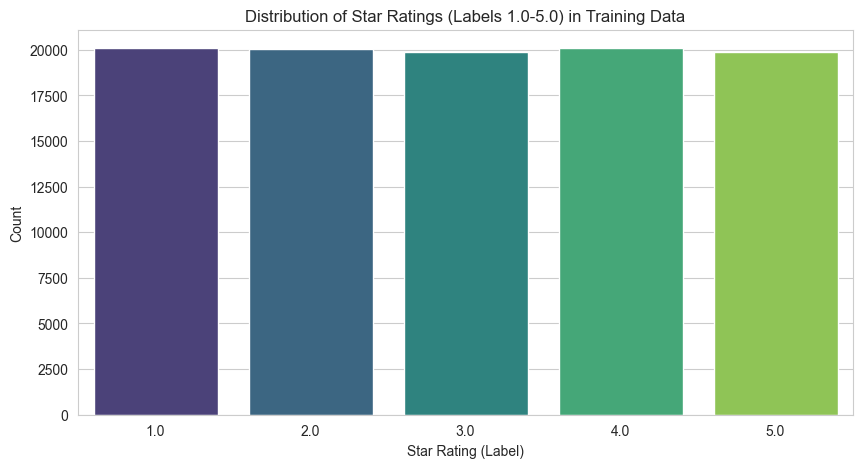


Value counts for 'labels':
labels
1.0    20096
2.0    20027
3.0    19893
4.0    20094
5.0    19890
Name: count, dtype: int64


In [9]:
# Cell 3.4: Target Variable Analysis (Star Ratings)

if not train_df_eda.empty:
    print("\n--- Target Variable Analysis ('labels') ---")

    # Distribution of star ratings
    plt.figure(figsize=(10, 5))
    sns.countplot(x='labels', data=train_df_eda, palette="viridis", order=sorted(train_df_eda['labels'].unique()))
    plt.title('Distribution of Star Ratings (Labels 1.0-5.0) in Training Data')
    plt.xlabel('Star Rating (Label)')
    plt.ylabel('Count')
    plt.show()

    print("\nValue counts for 'labels':")
    print(train_df_eda['labels'].value_counts().sort_index())
else:
    print("Skipping target variable analysis as DataFrame is empty.")


--- Text Feature Analysis (Review Length) ---

Descriptive statistics for review lengths:
       review_length_chars  review_length_words
count        100000.000000        100000.000000
mean            732.305620           134.070710
std             662.611501           121.160982
min               1.000000             1.000000
25%             287.000000            52.000000
50%             539.000000            99.000000
75%             960.000000           176.000000
max            5096.000000          1034.000000


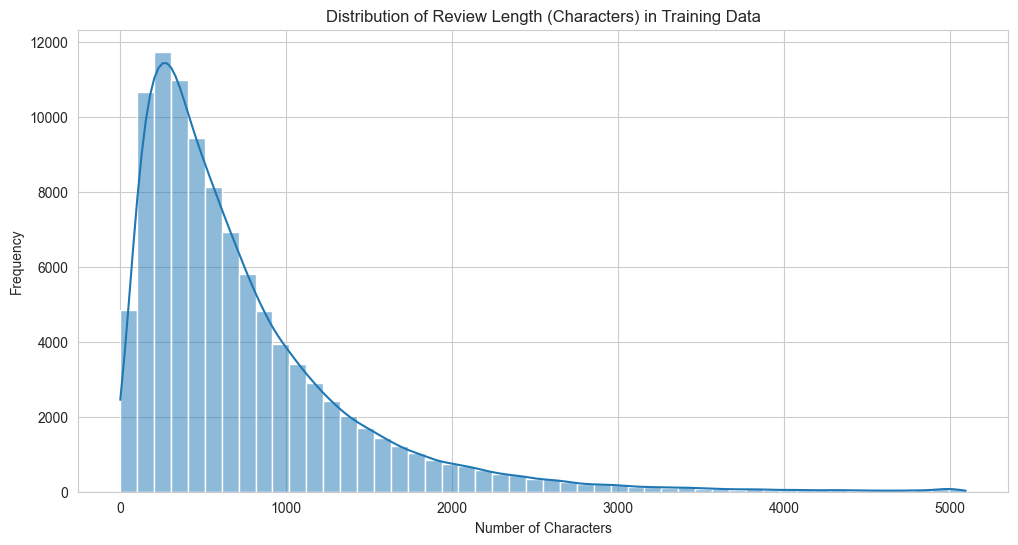

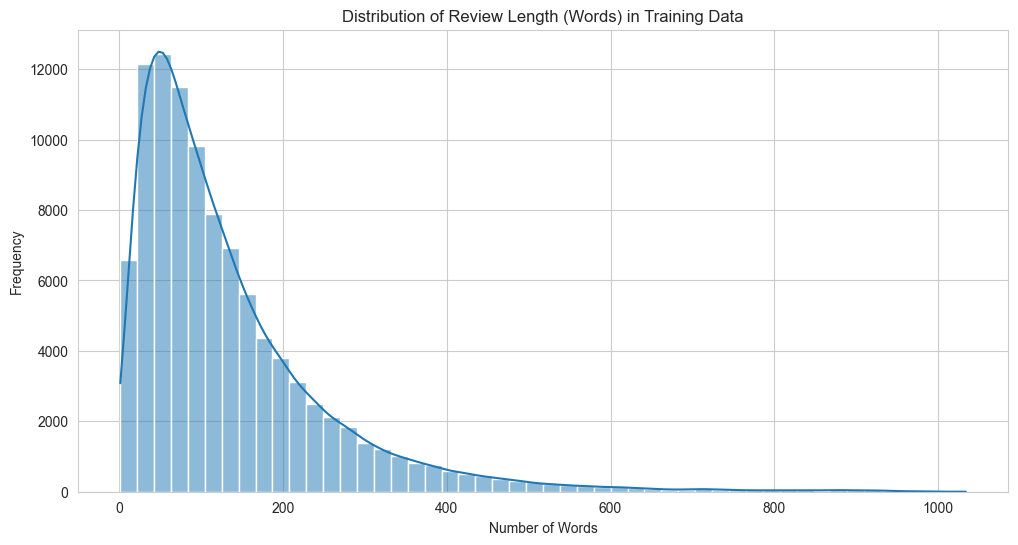

In [10]:
# Cell 3.5: Text Feature Analysis (Review Length)

if not train_df_eda.empty:
    print("\n--- Text Feature Analysis (Review Length) ---")

    # Calculate review length in characters
    train_df_eda['review_length_chars'] = train_df_eda['text'].apply(len)

    # Calculate review length in words
    train_df_eda['review_length_words'] = train_df_eda['text'].apply(lambda x: len(x.split()))

    print("\nDescriptive statistics for review lengths:")
    print(train_df_eda[['review_length_chars', 'review_length_words']].describe())

    # Plot distribution of review length (characters)
    plt.figure(figsize=(12, 6))
    sns.histplot(train_df_eda['review_length_chars'], bins=50, kde=True)
    plt.title('Distribution of Review Length (Characters) in Training Data')
    plt.xlabel('Number of Characters')
    plt.ylabel('Frequency')
    # Limiting x-axis for better visualization if there are extreme outliers
    # plt.xlim(0, train_df_eda['review_length_chars'].quantile(0.99))
    plt.show()

    # Plot distribution of review length (words)
    plt.figure(figsize=(12, 6))
    sns.histplot(train_df_eda['review_length_words'], bins=50, kde=True)
    plt.title('Distribution of Review Length (Words) in Training Data')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    # plt.xlim(0, train_df_eda['review_length_words'].quantile(0.99))
    plt.show()
else:
    print("Skipping text feature analysis as DataFrame is empty.")


--- Relationship between Review Length and Ratings ---


C:\Users\Granbell\AppData\Local\Temp\ipykernel_6200\3618738214.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='labels', y='review_length_words', data=train_df_eda, palette="coolwarm")


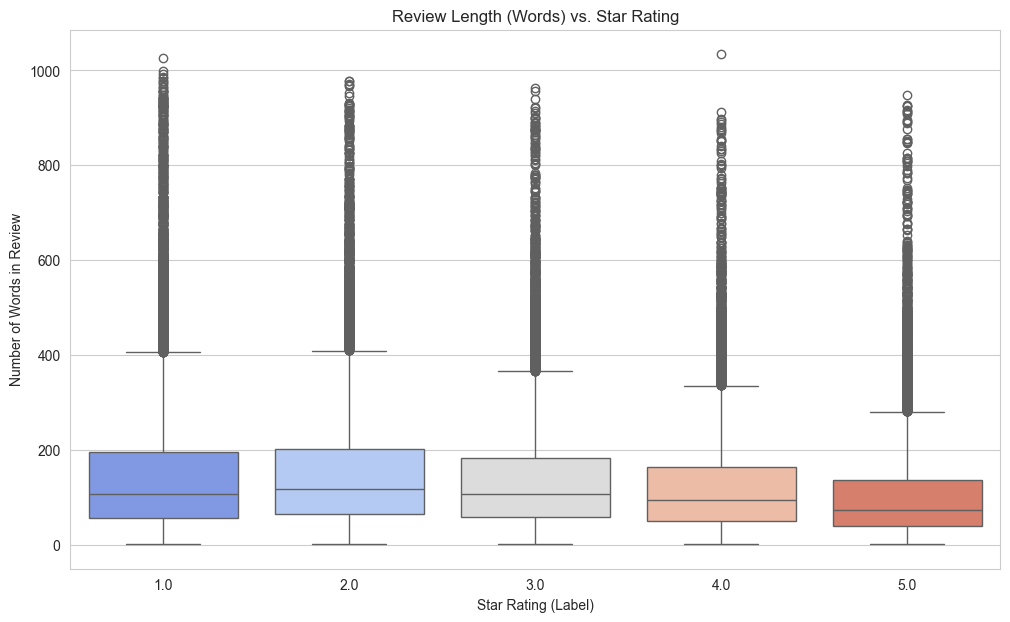


Average review length (words) per star rating:
labels
1.0    150.587032
2.0    152.676537
3.0    138.518072
4.0    123.519558
5.0    104.860684
Name: review_length_words, dtype: float64


In [11]:
# Cell 3.6: Relationship between Review Length and Ratings

if not train_df_eda.empty and 'review_length_words' in train_df_eda.columns:
    print("\n--- Relationship between Review Length and Ratings ---")

    plt.figure(figsize=(12, 7))
    sns.boxplot(x='labels', y='review_length_words', data=train_df_eda, palette="coolwarm")
    plt.title('Review Length (Words) vs. Star Rating')
    plt.xlabel('Star Rating (Label)')
    plt.ylabel('Number of Words in Review')
    # Optional: Limit y-axis if outliers make the boxplot hard to read
    # plt.ylim(0, train_df_eda['review_length_words'].quantile(0.95)) # Show up to 95th percentile
    plt.show()

    # You can also look at the average length per rating
    print("\nAverage review length (words) per star rating:")
    print(train_df_eda.groupby('labels')['review_length_words'].mean())
else:
    print("Skipping review length vs. ratings analysis as DataFrame or 'review_length_words' column is missing.")

In [12]:
# Cell 3.7: Display Sample Reviews per Rating

if not train_df_eda.empty:
    print("\n--- Sample Reviews per Star Rating ---")

    # Ensure 'labels' column exists and has unique values to sample from
    if 'labels' in train_df_eda.columns:
        unique_labels = sorted(train_df_eda['labels'].unique())

        for rating in unique_labels:
            if rating in [1.0, 3.0, 5.0]: # Show for 1, 3, and 5 stars, or adjust as needed
                print(f"\n--- Examples for {int(rating)}-star reviews ---")
                sample_reviews = train_df_eda[train_df_eda['labels'] == rating]['text'].sample(min(3, len(train_df_eda[train_df_eda['labels'] == rating])), random_state=SEED)
                for i, review in enumerate(sample_reviews):
                    print(f"Review {i+1}: {review[:300]}...") # Print first 300 characters
    else:
        print("Could not find 'labels' column to display sample reviews.")
else:
    print("Skipping display of sample reviews as DataFrame is empty.")

print("\nEDA on training data completed.")


--- Sample Reviews per Star Rating ---

--- Examples for 1-star reviews ---
Review 1: We went there for Christmas pictures of our twin boys, and got shafted!! First, the photographer saw us coming, got up from the station, walked passed us and mumbled \"have a seat\"... Then, when he got back from whatever he ran off to do (wasn't the bathroom because that's where I went), he seemed ...
Review 2: Take out tonight; 2 pasta dishes to go. \n\nProbably could've put each $11 Entree's contents in a red solo cup.\n\nWeak and wont be back....
Review 3: Well, here it is -- July 27th and they still are slow rolling me on my insurance claim.  What a crappy company....

--- Examples for 3-star reviews ---
Review 1: I've never been a great fan of Gregg's they seem to be taking over the high street where ever you go. \nI don't think a lot of baking goes on in these stored these days just defrost and serve unless you count the pie section, defrost, bake, serve.\nWhen I've come to this store on a Sun

In [13]:
# Cell 4: Tokenization

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
print(f"\nTokenizer loaded: {MODEL_NAME}")

def tokenize_function(examples):
    # Tokenize the 'text' field.
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=MAX_LENGTH)

# Apply tokenization to all splits in the DatasetDict
tokenized_datasets = final_datasets.map(tokenize_function, batched=True)

# Remove the original 'text' column as it's no longer needed after tokenization
# Also ensure 'labels' is the correct column name for targets.
tokenized_datasets = tokenized_datasets.remove_columns(['text'])

# Set the format to PyTorch tensors
tokenized_datasets.set_format('torch')

print("\nTokenization complete. Sample from tokenized train dataset:")
print(tokenized_datasets['train'][0])
# Check for 'input_ids', 'attention_mask', and 'labels' keys.


Tokenizer loaded: distilbert-base-uncased


Map: 100%|██████████████████████████████████████████████████████████████| 15000/15000 [00:05<00:00, 2784.45 examples/s]


Tokenization complete. Sample from tokenized train dataset:
{'labels': tensor(5.), 'input_ids': tensor([  101,  1045, 23899,  2023,  4744,  1012,  1045,  1005,  2310,  2042,
         2000,  3919,  6328,  2073,  1045,  9811,  2000,  2022,  1037,  6627,
         7309,  3061,  1999,  2240,  1010,  6167,  6670,  5581,  7167,  1010,
         1998,  1997,  2607,  1996,  7500,  1005,  1055,  3006,  1012,  1996,
        15220,  2024,  2061,  2061,  7078,  7746,  1012,  1996,  3954,  2003,
         3565,  5379,  1998,  2002,  3084,  2169,  4605,  2011,  2192,  2007,
         2019,  9788,  3815,  1997,  6620,  1012,  2017, 10657,  4521,  2182,
         4364,   999,   999,   999,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,   

In [14]:
# Cell 5: Load Model

model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=1  # CRITICAL for regression: num_labels is 1
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"\nModel '{MODEL_NAME}' loaded for sequence classification with num_labels=1.")
print(f"Model is on device: {device}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model 'distilbert-base-uncased' loaded for sequence classification with num_labels=1.
Model is on device: cuda


In [15]:
# Cell 6: Define Metrics Function

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred # eval_pred is a tuple of (predictions, labels)
    # For regression, logits are the direct predictions.
    # Ensure labels are also 2D array for metric functions if they expect it
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    rmse = np.sqrt(mse)

    return {
        "mse": mse,
        "mae": mae,
        "r2": r2,
        "rmse": rmse
    }
print("\nMetrics computation function defined.")


Metrics computation function defined.


In [16]:
# Cell 7: Training Arguments

OUTPUT_DIR = './results/yelp_review_regression' # Directory to save model checkpoints and logs

# Calculate warmup steps and logging steps dynamically
# Aim for warmup for ~10% of first epoch, log ~10-20 times per epoch
if len(tokenized_datasets['train']) > 0 and BATCH_SIZE > 0:
    steps_per_epoch = len(tokenized_datasets['train']) // BATCH_SIZE
    if steps_per_epoch == 0: steps_per_epoch = 1 # Avoid division by zero for very small datasets

    gradient_accumulation_steps = 1 # Assuming no gradient accumulation for simplicity here
    actual_steps_per_epoch = steps_per_epoch // gradient_accumulation_steps

    WARMUP_STEPS = max(1, actual_steps_per_epoch // 10) # e.g., 10% of first epoch steps
    LOGGING_STEPS = max(1, actual_steps_per_epoch // 10) # Log ~10 times per epoch
else:
    WARMUP_STEPS = 100 # Fallback
    LOGGING_STEPS = 50 # Fallback

print(f"Calculated WARMUP_STEPS: {WARMUP_STEPS}, LOGGING_STEPS: {LOGGING_STEPS}")


training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=WARMUP_STEPS,
    weight_decay=0.01,                     # Standard weight decay
    logging_dir=f'{OUTPUT_DIR}/logs',
    logging_steps=LOGGING_STEPS,
    eval_strategy="epoch",           # Evaluate at the end of each epoch - CHANGED from evaluation_strategy
    save_strategy="epoch",                 # Save model checkpoint at the end of each epoch
    load_best_model_at_end=True,           # Load the best model found during training at the end
    metric_for_best_model="mae",           # Use MAE to select the best model (lower is better)
    greater_is_better=False,               # For MAE/MSE/RMSE, lower is better
    fp16=torch.cuda.is_available(),        # Use mixed precision if a GPU is available
    report_to="tensorboard",               # Can also be "wandb" or "none"
    seed=SEED,
    # For newer transformers versions, learning_rate can be set here. Default is 5e-5.
)
print("\nTrainingArguments defined.")

Calculated WARMUP_STEPS: 625, LOGGING_STEPS: 625

TrainingArguments defined.


In [17]:
# Cell 8: Initialize Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics_for_regression,
    tokenizer=tokenizer # Pass tokenizer for easy saving with model
)
print("\nTrainer initialized.")


Trainer initialized.


C:\Users\Granbell\AppData\Local\Temp\ipykernel_6200\2623286105.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [18]:
# Cell 9: Train the Model

print("\nStarting training...")
try:
    train_results = trainer.train()
    print("Training finished.")
    # Save training metrics
    trainer.log_metrics("train", train_results.metrics)
    trainer.save_metrics("train", train_results.metrics)
except Exception as e:
    print(f"An error occurred during training: {e}")
    # Potentially add more robust error handling or debugging info here
    raise


Starting training...


Epoch,Training Loss,Validation Loss,Mse,Mae,R2,Rmse
1,0.468300,0.439848,0.439848,0.490875,0.780003,0.663210
2,0.319200,0.393393,0.393393,0.452097,0.803239,0.627210


Training finished.
***** train metrics *****
  epoch                    =        2.0
  total_flos               = 12336767GF
  train_loss               =      0.498
  train_runtime            = 0:28:04.54
  train_samples_per_second =    118.727
  train_steps_per_second   =       7.42


In [19]:
# Cell 11: Save the Fine-Tuned Model and Tokenizer

# The Trainer already saved the best model if load_best_model_at_end=True
# This explicitly saves the final (best) model to a specific path for easier access later.
best_model_path = f"{OUTPUT_DIR}/best_fine_tuned_model"
trainer.save_model(best_model_path)
# Tokenizer was passed to Trainer, so it should be saved alongside the model.
# If not, or for explicitness:
# tokenizer.save_pretrained(best_model_path)
print(f"\nBest model and tokenizer saved to {best_model_path}")


Best model and tokenizer saved to ./results/yelp_review_regression/best_fine_tuned_model


In [20]:
# Cell 12: Inference Example

# Load the fine-tuned model and tokenizer (demonstrating how to load it later)
# model_fine_tuned = DistilBertForSequenceClassification.from_pretrained(best_model_path)
# tokenizer_fine_tuned = DistilBertTokenizerFast.from_pretrained(best_model_path)
# model_fine_tuned.to(device) # Ensure it's on the GPU

# For this example, we can use the 'model' instance from the Trainer,
# as it's already the best model if load_best_model_at_end=True.

sample_reviews = [
    "This is the best game I have ever played! Absolutely stunning graphics and addictive gameplay. A masterpiece!", # Expect high rating (e.g., ~5.0)
    "I was extremely disappointed. The product arrived broken and customer service was unhelpful.", # Expect low rating (e.g., ~1.0)
    "It's an okay product. Does what it says, but nothing outstanding. Pretty average experience.", # Expect mid rating (e.g., ~3.0)
    "What a complete waste of money. Buggy, boring, and looks terrible. Avoid at all costs!", # Expect very low rating (e.g., ~1.0-2.0)
    "Decent for the price. A few minor issues but overall I'm satisfied with my purchase.", # Expect mid-to-high rating (e.g., ~3.5-4.5)
    "It's alright for the price, I think there is more room for improvement.", # Expect mid-to-high rating (e.g., ~3.5-4.5)
    "pretty cool",
    "nice",
    "This Machine learning team was really great! They presented their project well and had me in awe!",
    "alright",
    "meh",
    "good job",
    "wow",
    "stinks",
    "lowkey good",
    "good",
    "stupidly good",
    "excellently ugly",
    "This product is suprisingly good but ugly at the same time",
    "This product is suprisingly good but bad at the same time",
    "not good and not bad",
    "so-so",
    "This product is so good it makes me wanna puke",
    "This product makes me cut-off my friends. I choose this product over my friends",
    "This product makes me cut-off my friends",
    "I choose this product over my friends",
    "This product makes the whole america cry in tears due to it's popularity",
    "Progress Stumbles on the Very Tools Meant to Liberate It",
    "This product makes my boyfriend cut-off all of his friends. He chose this product over his friends because it is so pretty and good."


]

print("\n--- Inference Examples ---")
model.eval() # Ensure model is in evaluation mode

for review_text in sample_reviews:
    inputs = tokenizer(
        review_text,
        return_tensors="pt", # PyTorch tensors
        truncation=True,
        padding=True,        # Pad to max_length or batch max if dynamic
        max_length=MAX_LENGTH
    )
    # Move inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad(): # Disable gradient calculations for inference
        outputs = model(**inputs)
        predicted_score = outputs.logits.item() # .item() to get Python number from a single-element tensor

    print(f"Review: \"{review_text}\"")
    print(f"Predicted Star Rating: {predicted_score:.2f}\n")


--- Inference Examples ---
Review: "This is the best game I have ever played! Absolutely stunning graphics and addictive gameplay. A masterpiece!"
Predicted Star Rating: 5.11

Review: "I was extremely disappointed. The product arrived broken and customer service was unhelpful."
Predicted Star Rating: 1.50

Review: "It's an okay product. Does what it says, but nothing outstanding. Pretty average experience."
Predicted Star Rating: 2.81

Review: "What a complete waste of money. Buggy, boring, and looks terrible. Avoid at all costs!"
Predicted Star Rating: 1.08

Review: "Decent for the price. A few minor issues but overall I'm satisfied with my purchase."
Predicted Star Rating: 3.37

Review: "It's alright for the price, I think there is more room for improvement."
Predicted Star Rating: 2.91

Review: "pretty cool"
Predicted Star Rating: 3.68

Review: "nice"
Predicted Star Rating: 4.09

Review: "This Machine learning team was really great! They presented their project well and had me in a

In [21]:
# prompt: Evaluate on test set

# Cell 13: Evaluate on Test Set

print("\n--- Evaluating on Test Set ---")

# Use the Trainer's evaluate method on the test split
# Ensure the test split exists in tokenized_datasets
if 'test' in tokenized_datasets:
    try:
        test_results = trainer.evaluate(tokenized_datasets['test'])
        print("\nTest Set Evaluation Results:")
        # The test_results dictionary contains the metrics computed by compute_metrics_for_regression
        for metric_name, value in test_results.items():
            print(f"{metric_name}: {value:.4f}")

        # Save test metrics
        trainer.log_metrics("test", test_results)
        trainer.save_metrics("test", test_results)

    except Exception as e:
        print(f"An error occurred during test set evaluation: {e}")
else:
    print("Test dataset split not found in tokenized_datasets. Cannot perform test evaluation.")

print("\nEvaluation process finished.")


--- Evaluating on Test Set ---



Test Set Evaluation Results:
eval_loss: 0.4030
eval_mse: 0.4030
eval_mae: 0.4552
eval_r2: 0.7983
eval_rmse: 0.6349
eval_runtime: 33.6135
eval_samples_per_second: 446.2500
eval_steps_per_second: 27.9050
epoch: 2.0000
***** test metrics *****
  epoch                   =        2.0
  eval_loss               =      0.403
  eval_mae                =     0.4552
  eval_mse                =      0.403
  eval_r2                 =     0.7983
  eval_rmse               =     0.6349
  eval_runtime            = 0:00:33.61
  eval_samples_per_second =     446.25
  eval_steps_per_second   =     27.905

Evaluation process finished.


In [22]:
# Cell 14: Zip and Download the Fine-Tuned Model

import shutil
import os
from IPython.display import FileLink

# --- Configuration for Zipping ---
# These should have been set in previous cells:
# - OUTPUT_DIR (e.g., './results/yelp_review_regression') from Cell 7
# - best_model_path (e.g., f"{OUTPUT_DIR}/best_fine_tuned_model") from Cell 11

# Define the desired basename for the ZIP file (without .zip extension)
ZIP_FILE_BASENAME = "fine_tuned_yelp_distilbert_model"

try:
    # --- Verify necessary variables and paths ---
    if 'OUTPUT_DIR' not in globals():
        raise NameError("OUTPUT_DIR is not defined. Please ensure Cell 7 (Training Arguments) has been run.")
    if 'best_model_path' not in globals():
        raise NameError("best_model_path is not defined. Please ensure Cell 11 (Save Model) has been run.")

    if not os.path.isdir(best_model_path):
        print(f"Error: The model directory '{best_model_path}' does not exist.")
        print("Please ensure Cell 11 has run successfully and the model was saved.")
    else:
        print(f"Found model directory to zip: {best_model_path}")

        # --- Define paths for zipping ---
        # The ZIP file will be created in the OUTPUT_DIR.
        # base_name for shutil.make_archive is the path to the output file, minus any format-specific extension.
        zip_archive_path_without_extension = os.path.join(OUTPUT_DIR, ZIP_FILE_BASENAME)

        # The directory containing the folder to be zipped (e.g., './results/yelp_review_regression')
        root_directory_for_zip_op = os.path.dirname(best_model_path)
        if not root_directory_for_zip_op: # if best_model_path is like "my_model_folder" (no parent dir)
            root_directory_for_zip_op = "."


        # The name of the folder to be zipped (e.g., 'best_fine_tuned_model')
        folder_to_zip_name = os.path.basename(best_model_path)

        print(f"\nAttempting to create ZIP archive: {zip_archive_path_without_extension}.zip")
        print(f"  Root directory for archiving: '{root_directory_for_zip_op}'")
        print(f"  Base directory to archive: '{folder_to_zip_name}'")

        # --- Create the ZIP archive ---
        # This will create a zip file named 'fine_tuned_yelp_distilbert_model.zip'
        # inside the OUTPUT_DIR. The zip file will contain the 'best_fine_tuned_model' folder.
        shutil.make_archive(
            base_name=zip_archive_path_without_extension, # Path for the output zip, without extension
            format='zip',                                 # Format of the archive
            root_dir=root_directory_for_zip_op,           # Directory to change to before archiving
            base_dir=folder_to_zip_name                   # Directory to archive (relative to root_dir)
        )

        final_zip_file_path = zip_archive_path_without_extension + ".zip"

        if os.path.exists(final_zip_file_path):
            print(f"\nSuccessfully created ZIP file: {final_zip_file_path}")
            print(f"File size: {os.path.getsize(final_zip_file_path) / (1024*1024):.2f} MB")

            # --- Display a download link for the ZIP file ---
            print("\nDownload the model ZIP file using the link below:")
            display(FileLink(final_zip_file_path))
        else:
            print(f"\nError: ZIP file was not created at {final_zip_file_path}")

except NameError as ne:
    print(f"Configuration Error: {ne}")
except FileNotFoundError as fnfe:
    print(f"File/Directory Not Found Error: {fnfe}")
    print("Please check if the model was saved correctly and paths are valid.")
except Exception as e:
    print(f"An unexpected error occurred during zipping or creating download link: {e}")

# --- Optional: For Google Colab, you might use files.download directly ---
# This part is commented out but can be useful if running in Colab.
# Make sure 'final_zip_file_path' is defined and the file exists.

import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB and 'final_zip_file_path' in locals() and os.path.exists(final_zip_file_path):
  print("\nAttempting to trigger download in Google Colab...")
  from google.colab import files
  files.download(final_zip_file_path)

Found model directory to zip: ./results/yelp_review_regression/best_fine_tuned_model

Attempting to create ZIP archive: ./results/yelp_review_regression\fine_tuned_yelp_distilbert_model.zip
  Root directory for archiving: './results/yelp_review_regression'
  Base directory to archive: 'best_fine_tuned_model'

Successfully created ZIP file: ./results/yelp_review_regression\fine_tuned_yelp_distilbert_model.zip
File size: 235.86 MB

Download the model ZIP file using the link below:


C:\Users\Granbell\Machine Learning\results\yelp_review_regression\fine_tuned_yelp_distilbert_model.zip